## Классификация текстов: Spam or Ham

В этом задании на примере классического датасета Spambase Dataset (https://archive.ics.uci.edu/ml/datasets/spambase) мы попробуем сделать свой спам-фильтр c помощью библиотеки scikit-learn. Датасет содержит корпус текстов 5,574 смс с метками "spam" и "ham".

### Данные

Для удобства данные приложены в описании задания

In [1]:
import pandas as pd
df = pd.read_csv('3_data.csv', encoding='latin-1')

Оставляем только интересующие нас колонки — тексты смс и метки:

In [2]:
df = df[['v1', 'v2']]
df = df.rename(columns = {'v1': 'label', 'v2': 'text'})
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Удаляем дублирующиеся тексты:

In [3]:
df = df.drop_duplicates('text')

Заменяем метки на бинарные:

In [4]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [5]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Предобработка текста (Задание 1)

Нужно дополнить функцию для предобработки сообщений, которая делает с текстом следующее:
* приводит текст к нижнему регистру;
* удаляет стоп-слова;
* удаляет знаки препинания;
* нормализует текст при помощи стеммера Snowball.

Предлагаем воспользоваться библиотекой nltk, чтобы не составлять список стоп-слов и не реализовывать алгоритм стемминга самостоятельно. Примеры использования стеммеров можно найти по ссылке (https://www.nltk.org/howto/stem.html).

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk import stem
from nltk.corpus import stopwords
import re

stemmer = stem.SnowballStemmer('english')
stopwords = set(stopwords.words('english'))

def preprocess(text):
    # Приводим текст к нижнему регистру
    text = text.lower()

    # Удаляем знаки препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Разбиваем текст на слова
    words = text.split()

    # Удаляем стоп-слова и применяем стемминг
    words = [stemmer.stem(word) for word in words if word not in stopwords]

    # Соединяем слова обратно в текст
    text = ' '.join(words)

    return text

Проверка, что функция работает верно

In [8]:
assert preprocess("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.") == "im gonna home soon dont want talk stuff anymor tonight k ive cri enough today"
assert preprocess("Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...") == "go jurong point crazi avail bugi n great world la e buffet cine got amor wat"

Применяем получившуюся функцию к текстам:

In [9]:
df['text'] = df['text'].apply(preprocess)

### Разделение данных на обучающую и тестовую выборки (Задание 2)

In [10]:
y = df['label'].values

Теперь нужно разделить данные на тестовую (test) и обучающую (train) выборку. В библиотеке scikit-learn для этого есть готовые инструменты.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.3, random_state=51)

### Обучение классификатора (Задание 3)

Переходим к обучению классификатора.

Сначала извлекаем признаки из текстов. Рекомендуем попробовать разные способы и посмотреть, как это влияет на результат (подробнее о различных способах представления текстов можно прочитать по ссылке https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

Затем обучаем классификатор. Мы используем SVM, но можно поэкспериментировать с различными алгоритмами.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# извлекаем признаки из текстов
vectorizer = TfidfVectorizer(decode_error='ignore')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Обучаем подель SVM

model = LinearSVC(random_state = 51, C = 1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

Для самопроверки. Если вы верно дополнили функцию ```preprocess```, то должны получиться следующие результаты оценки модели.

In [14]:
print(classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.984     0.993     0.988      1355
           1      0.946     0.888     0.916       196

    accuracy                          0.979      1551
   macro avg      0.965     0.940     0.952      1551
weighted avg      0.979     0.979     0.979      1551



Выполним предсказание для конкретного текста

In [15]:
txt = "As a valued customer, I am pleased to advise you that following recent review of your Mob No. you are awarded with a å£1500 Bonus Prize, call 09066364589"
txt = preprocess(txt)
txt = vectorizer.transform([txt])

In [16]:
model.predict(txt)

array([1])

Сообщение помечено как спам.

# Индивидуальное задание

Используя в качестве исходного набора данных датасет [Spambase Dataset](https://courses.openedu.ru/assets/courseware/v1/008dcf9ca6aab621d3b3831db6815867/asset-v1:ITMOUniversity+AUTXTIMGPROC+spring_2024_ITMO_mag+type@asset+block/3_data.csv) (тот же, что и в примере), постройте модель для определения является ли сообщение спамом.  

Выполните предварительную обработку текста (как в примере) и разделите датасет на тренировочный и тестовый набор данных с параметрами `test_size = 0.25`, `random_state = 9`. Обучите классификатор SVM при `C = 1.2` и `random_state = 9` на обучающей выборке и произведите оценку полученной модели на тестовой.  

Оцените модель на тестовых данных.  
_Введите значение Precision (macro avg). Десятичный разделитель точка. Ответ округлите до тысячных:_
```
0.971
```
_Введите значение Recall (macro avg). Десятичный разделитель точка. Ответ округлите до тысячных:_
```
0.918
```
_Введите значение F-score (macro avg). Десятичный разделитель точка. Ответ округлите до тысячных.:_
```
0.943
```

_**Call 8890909838 to inquire about our degree programs. Whether you are seeking a Bachelors, Masters, Ph.D. or MBA.** 0 соответствует ham, 1 -- spam:_
```
0
```
_**I think this book is a must read for anyone who wants an insight into the Middle East.** 0 соответствует ham, 1 -- spam:_
```
0
```
_**Excellent collection of articles and speeches.** 0 соответствует ham, 1 -- spam:_
```
0
```
_**URGENT! We are trying to contact U.Todays draw shows that you have won a 2000 prize GUARANTEED. Call 090 5809 4507 from a landline. Claim 3030. Valid 12hrs only.** 0 соответствует ham, 1 -- spam:_
```
1
```


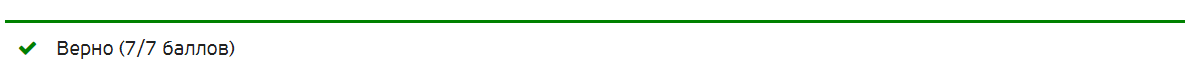

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [18]:
# Предобработка текста
df['text'] = df['text'].apply(preprocess)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.25, random_state=9)

# Извлекаем признаки
vectorizer = TfidfVectorizer(decode_error='ignore')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Обучаем классификатор SVM
model = LinearSVC(random_state=9, C=1.2)
model.fit(X_train, y_train)

# Производим оценку модели
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.976     0.996     0.986      1123
           1      0.966     0.841     0.899       170

    accuracy                          0.975      1293
   macro avg      0.971     0.918     0.943      1293
weighted avg      0.975     0.975     0.975      1293



In [19]:
messages = [
    "Call 8890909838 to inquire about our degree programs. Whether you are seeking a Bachelors, Masters, Ph.D. or MBA",
    "I think this book is a must read for anyone who wants an insight into the Middle East.",
    "Excellent collection of articles and speeches.",
    "URGENT! We are trying to contact U.Todays draw shows that you have won a 2000 prize GUARANTEED. Call 090 5809 4507 from a landline. Claim 3030. Valid 12hrs only."
]

messages = [preprocess(txt) for txt in messages]

messages = vectorizer.transform(messages)

predictions = model.predict(messages)

print(predictions)

[0 0 0 1]
